In [1]:
import pandas as pd
import tensorflow as tf
import seaborn

from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

from sent_functions import get_sent_flair as s_flair
from sent_functions import get_sent_nltk as s_nltk
from sent_functions import get_sent_textblob as s_textblob
from sent_functions import tokenize

c:\Users\thel0\OneDrive\Desktop\Sent Analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\thel0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
SEED = 0

In [3]:
#tqdm progress bar for pandas methods
tqdm.pandas()

In [4]:
# Read in data
df = pd.read_csv('data_test.csv', sep='\t')

In [5]:
# Sampling (optional)
#df = df.sample(n=1000, random_state = SEED)

In [6]:
df.head()

,sent,text,data_len,token_lens
0,0,hes not allowed to be an asshole on date night,10,13
1,0,us linux users are still waiting too although ...,18,20
2,0,i applaud your singleminded zeal in the face o...,22,30
3,1,watching the zoo with a hot milo oh and in fro...,14,17
4,0,yeh i seem to have lost that lovin feeling tow...,11,15


### Model Comparison

We start by applying the out-of-the-box sentiment analysis functions (s_flair, s_nltk, s_textblob) on our test data.

In [7]:
df['flair_sent'] = df['text'].progress_apply(s_flair)
df['nltk_sent'] = df['text'].progress_apply(s_nltk)
df['textblob_sent'] = df['text'].progress_apply(s_textblob)

100%|██████████| 231055/231055 [00:34<00:00, 6741.35it/s]


Initializing DistilBert model

In [8]:
model = TFDistilBertForSequenceClassification.from_pretrained('trained_distilbert_model')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at trained_distilbert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
MAX_LEN = 128

In [11]:
test_input_ids, test_attention_masks = tokenize(df.text.values, max_len=MAX_LEN)

100%|██████████| 231055/231055 [01:11<00:00, 3213.46it/s]


In [12]:
y = df['sent']
df.reset_index(inplace= True, drop= True)

In [15]:
dbert_preds = pd.DataFrame(tf.nn.softmax(model.predict([test_input_ids,test_attention_masks], batch_size=128).logits)).idxmax(axis=1)

1806/1806 [==============================] - 314s 174ms/step


In [16]:
df['DistilBert_sent'] = dbert_preds.values

In [17]:
plot_keys = ['flair', 'nltk', 'textblob', 'distilbert']
plot_data = [accuracy_score(df['sent'], df['flair_sent']),
             accuracy_score(df['sent'], df['nltk_sent']),
             accuracy_score(df['sent'], df['textblob_sent']),
             accuracy_score(df['sent'], df['DistilBert_sent'])
             ]

df_acc = pd.DataFrame({'model_name': plot_keys, 'accuracy': plot_data})

In [18]:
df_acc.head()

,model_name,accuracy
0,flair,0.700418
1,nltk,0.653788
2,textblob,0.626007
3,distilbert,0.907671


[Text(0, 0, '0.907671')]

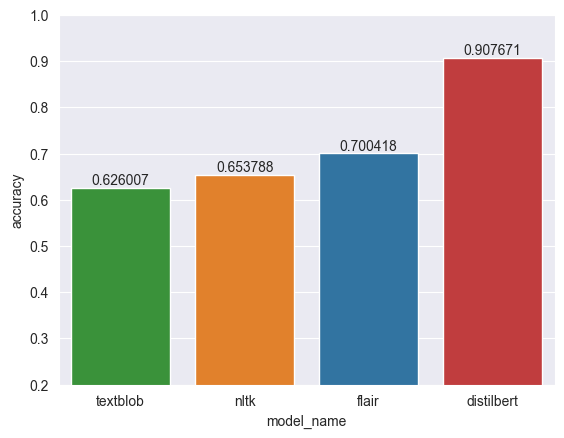

In [19]:
seaborn.set_style("darkgrid")

acc_plot = seaborn.barplot(
    data=df_acc,
    x='model_name',
    y='accuracy',
    order=df_acc.sort_values('accuracy').model_name,
    hue='model_name'
)

acc_plot.set_ylim(0.2, 1)

acc_plot.bar_label(acc_plot.containers[0])
acc_plot.bar_label(acc_plot.containers[1])
acc_plot.bar_label(acc_plot.containers[2])
acc_plot.bar_label(acc_plot.containers[3])

In [20]:
# save the plot as PNG file
acc_plot.figure.savefig("seaborn_plot.png")

In [21]:
dbert_conf_matrix = confusion_matrix(df['sent'], df['DistilBert_sent'])

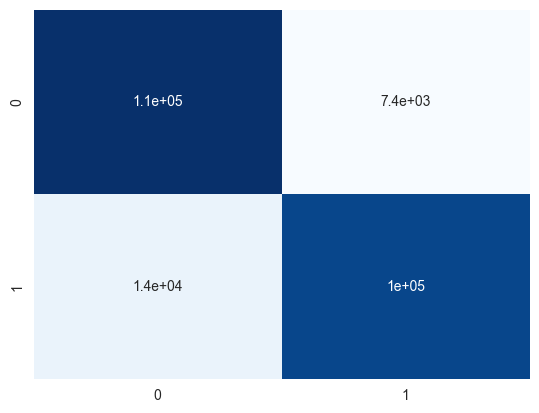

In [22]:
dbert_conf_matrix = seaborn.heatmap(dbert_conf_matrix, cmap= 'Blues', cbar= False, annot= True)

In [23]:
dbert_conf_matrix.figure.savefig("conf_matrix_dbert.png")